In [1]:
#User defines files
from TCN import TemporalConvolutionalNet
from Multivariate.Multivariate_preprocessing import mulitvariate_preprocessing
from Multivariate.feature_engineering import rsi, wwma, atr

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

The code below will help define some variables need run the program. It will also create training samples, validation samples and addition sample for testing and forecasting

In [2]:
############# Any forecast size >1 is multi-step/ horizon forecasting. due to the nature of the data
############## And the volatility this can lead to unaccurate predictions, therefore we need a recursive forecasting
###Method as well for when forecast_size = 5
np.set_printoptions(suppress=True)

window_size = 14
time_steps= 20 #input length
forecast_size = 1 #shift in y target as well

#for sliding window this is the number of sample you can predict, test_sample_size/forecast_size
#ie for sliding window size if forecast_size =1 -> there are 10 extra sample size, if slioding window = 2, there would be 5 extra samples
#for jump, this would need to be a multiple of timesteps

#Note that if the number of features change, so should the number of layers in the model, the shapes of the channels
#and the optimizer's hyper-parameters should be adjusted as well
list_of_features =['Close','dayofweek','rsi', 'atr'] # <- list of feature you want the model to take in.

#load data
# ticer_options = ['APPLE', 'TESLA', 'AT&T', 'S&P500']
ticker = 'APPLE'
cur_dir = Path(os.getcwd())
parent_path = cur_dir.parent
f_path = parent_path / 'data/{}.csv'.format(ticker)
df=pd.read_csv(f_path)

training_sample_size = math.ceil(df.shape[0] * .6)
validation_sample_size = math.ceil(df.shape[0] * .15)
sampling_Style = 'sliding_window' # sliding_window or jump
test_sample_size = math.ceil(df.shape[0] * .25)


sample = df[['Date','Open','High','Low','Close','Volume']] #need to ensure extra data for y-target series forecasting
sample['Date']= pd.to_datetime(sample['Date'], format ='%Y-%m-%d' ) #convert string to date time
sample['dayofweek']= sample['Date'].dt.dayofweek


sample_rsi = rsi(sample, window_size)

sample_rsi = sample_rsi.set_index('Date')
start_index =((sample.shape[0]-window_size)%time_steps + window_size)
sample_rsi = sample_rsi[start_index:]#cutoff NaN
atr_values = atr(sample_rsi)
sample_rsi['atr'] = atr_values 

sample_rsi = sample_rsi[list_of_features]  # predicting feature should be in column index 0

num_features = sample_rsi.shape[1]

training_cutoff = training_sample_size + forecast_size 
validation_cutoff = time_steps + training_cutoff + validation_sample_size + forecast_size
forecast_testing_cut = time_steps + validation_cutoff  + test_sample_size


train = sample_rsi[:training_cutoff].copy()
val = sample_rsi[training_cutoff:validation_cutoff].copy()
forecast = sample_rsi[validation_cutoff:forecast_testing_cut].copy()
#print(forecast)

X_train, y_train = mulitvariate_preprocessing(num_features,time_steps,train,forecast_size,'sliding_window' ) #or jump

X_val, y_val = mulitvariate_preprocessing(num_features,time_steps,val, forecast_size,'sliding_window')

X_fore, y_fore = mulitvariate_preprocessing(num_features,time_steps,forecast, forecast_size,'sliding_window')


print('Test data size, x-shape, y - shape: ', training_cutoff, X_train.shape, y_train.shape)
print('Validation data size, x-shape, y - shape: ',  validation_cutoff - training_cutoff, X_val.shape, y_val.shape )
print('Forecast data size, x-shape, y - shape: ', forecast_testing_cut - validation_cutoff, X_fore.shape, y_fore.shape )

Finish resampling
Finish resampling
Finish resampling
Test data size, x-shape, y - shape:  603 torch.Size([583, 4, 20]) torch.Size([583, 1, 20])
Validation data size, x-shape, y - shape:  172 torch.Size([152, 4, 20]) torch.Size([152, 1, 20])
Forecast data size, x-shape, y - shape:  271 torch.Size([185, 4, 20]) torch.Size([185, 1, 20])


Here the data is in the right shape and ready to be inputed in to the model, however we need to define the model first To define the model we should know the size of the kernel, how many filters and layers the TCN would require

In [3]:
in_channels = num_features
out_channel = 1
filter_size = 3
#receptive field = 1 + 2*(kernel_size -1)*(dilation_base^n -1) where n is the nth layer, so we need to solve for n
num_layers = math.ceil(math.log((X_train.shape[2]-1)/(2*(filter_size - 1))+1,2))
channels = [2,out_channel]
print('Current layers', len(channels))
if len(channels) != num_layers:
    print('You should not have more than {} residual layers or else model will be equivalent to RNN'.format(num_layers))

Current layers 2
You should not have more than 3 residual layers or else model will be equivalent to RNN


Model Definition

In [4]:
model = TemporalConvolutionalNet(in_channels,channels,kernel_size = filter_size,dropout=0.2,weight_normal=True)

layers
4 2
2 1


In [5]:
##Training Model
# The number of times to evaluate the full training data (in this case, number of gradient steps)
num_epoch = 500

loss = torch.nn.MSELoss()
# Use stochastic gradient descent to train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.015, betas=(0.45,0.35), weight_decay=0.4)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.015, betas=(0.56,0.42), weight_decay=0.3) <-alternative hyper params


for epoch in range(1, num_epoch): 
    
        y_pred = model(X_train)                   # Make predictions (final-layer activations)
        loss_value = loss(y_pred, y_train)                 # Compute loss with respect to predictions
        #print(y_pred)
        
        model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
        loss_value.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
        optimizer.step()                    # Use the gradients to take a step with SGD.
        
        if epoch % 20 == 0:
            print("Epoch %d final had loss %.4f" % (epoch, loss_value.item()))
        
        

Epoch 20 final had loss 243.4438
Epoch 40 final had loss 11.9442
Epoch 60 final had loss 4.0283
Epoch 80 final had loss 2.0272
Epoch 100 final had loss 0.8079
Epoch 120 final had loss 1.1330
Epoch 140 final had loss 1.1379
Epoch 160 final had loss 0.5183
Epoch 180 final had loss 0.5231
Epoch 200 final had loss 1.1641
Epoch 220 final had loss 0.6549
Epoch 240 final had loss 0.4673
Epoch 260 final had loss 0.5471
Epoch 280 final had loss 0.8835
Epoch 300 final had loss 0.7524
Epoch 320 final had loss 0.7244
Epoch 340 final had loss 0.9443
Epoch 360 final had loss 0.5893
Epoch 380 final had loss 0.4812
Epoch 400 final had loss 0.5624
Epoch 420 final had loss 0.8547
Epoch 440 final had loss 0.7123
Epoch 460 final had loss 0.5550
Epoch 480 final had loss 0.4681


Here we tested the trained data to see if if the average validation loss is low enough. The reason the average is looked at is because the nature of the data is that it can be volatile. A good model should be able to hand the volatility.

average validaiton loss : 1.2572371973411034


Text(0.5, 1.0, 'Validation Loss')

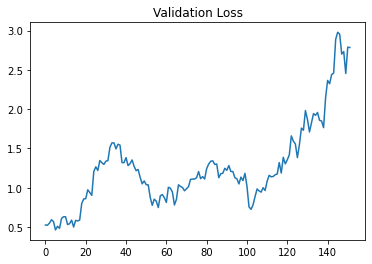

In [6]:
#Validating Model
validation_loss = []
with torch.no_grad():
    model.eval() #stops dropout
    for i in range(X_val.shape[0]):
        x_input = X_val[i:i+1,:,:]
        y_target = y_val[i:i+1,:,:]
        
        y_hat = model(x_input)                   
        val_loss = loss(y_hat, y_target)
        validation_loss.append(val_loss.item())
        
print('average validaiton loss :', np.mean(np.array(validation_loss)))
plt.plot(np.arange(len(validation_loss)),validation_loss,label='Loss')
plt.title('Validation Loss')

Given a new set of data we will input it into the model to determine what it predicts


Recall:
Forecasting via sliding window approach
Input and Output are the same length.
We shift the target series by time num_predictions
thus the difference between the input and output will be the prediction of len num_predictions

Ex:
num_predictions = 2
input : t1,t2,t3,t4,t5 
target : t3,t4,t5,t6,t7
predictions = t6,t7
Your total data should be input + ti i in 1...n where n is num_predictions and input would have len time_steps, so
t1,t2,t3,t4,t5,t6,t7

model(input) -> output where len(output) = len(input) and where values 0...len(input)-num_predictions are already
known to the model

thus if you tail total_data.tail(num_predictions) you get the actual values of t5+i where i is in  1...num_predictions


In [7]:
model.eval()
forecasted = []
for sample in range(X_fore.shape[0]):
    sample_input = X_fore[sample:sample+1,:,:]
    y_pred_fore = model(sample_input)
    #print(X_fore[sample:sample+1,0:1,:])
    #print(y_pred_fore)
    y_pred_fore_val = y_pred_fore.detach().numpy().reshape(-1) # entirety of model ouput in 1D array
    y_fore_hat = y_pred_fore_val[y_pred_fore.shape[2]-forecast_size:] # forcasted aka shifted y, take last forecast_size elements
    forecasted.append(y_fore_hat[0])
    #print(y_fore_hat)
    

RMSE Loss for forecasted value(s):  2.8940111157883144


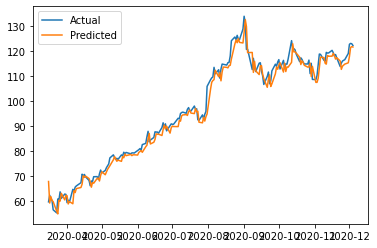

In [8]:
# last forecast_size sample, here these are the actual values of t+1,t+2... 
#assuming sliding window style
y_pred_actual = forecast['Close'].tail(X_fore.shape[0])

plt.plot(y_pred_actual.index,y_pred_actual.to_numpy(),label = 'Actual')
plt.plot(y_pred_actual.index,forecasted,label = 'Predicted')
plt.legend()
#print('Actual: ',y_pred_actual.to_numpy())
#print('Forecasted: ',forecasted )

forecasted_loss = math.sqrt(mean_squared_error(forecasted,y_pred_actual.to_numpy()))
print('RMSE Loss for forecasted value(s): ', forecasted_loss)
#print('Loss on the Dollar: ', np.sum(y_pred_actual.to_numpy() - forecasted))